# Dispatchable Renewable Electricity Offers Higher Energy Return on Investment than Carbon Capture and Storage Under Realistic Conditions 
*Sgouridis, Carbajales-Dale, Csala, Chiesa, Bardi*

Use this Jupyter workbook to reproduce all results presented in the paper.

<p>This is document has been created using  <a target="_blank" href="http://jupyter.org/">Jupyter Notebook</a> in the <a target="_blank" href="https://store.continuum.io/cshop/anaconda/">Anaconda</a> distribution and it can be edited and run in <i>active</i> mode by clicking download in top right corner of this page. The code is partitioned into sections, called <i>cells</i>. When you are using this workbook in <i>active</i> mode, double-click on a cell to edit it and then run using <code>Ctrl + Enter</code>. Hitting <code>Shift + Enter</code> runs the code and steps into the next cell, while <code>Alt + Enter</code> runs the code and adds a new, empty cell. If you are running this notebook on a presonal computer, you will need a machine with at least <i>1GB</i> of memory (<i>2GB</i> recommended) and a processor of <i>1GHz</i>.

Import dependencies

In [80]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
import matplotlib.lines as lines
%matplotlib inline
import sys, string
from sympy import *
init_printing() 
print 'Running on Python',sys.version

Running on Python 2.7.14 |Anaconda, Inc.| (default, Nov  8 2017, 13:40:45) [MSC v.1500 64 bit (AMD64)]


### Fossil fuels part

#### Equations

In [81]:
var('EROEI E_out E_in');
eq_S1=Eq(EROEI,E_out/E_in)
eq_S1

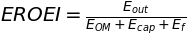

In [82]:
var('E_cap E_f E_OM');
eq_S1i=Eq(EROEI,E_out/(E_cap+E_OM+E_f))
eq_S1i

In [83]:
var('L s_OM');
eq_S2a=Eq(E_in,E_cap*(1+L*s_OM)+E_f)
eq_S2a

In [84]:
k=Symbol('kappa')
var('P L');
eq_S2b=Eq(E_out,P*k*L)
eq_S2b

In [85]:
var('E_el');
eq_S2bi=Eq(E_out,E_el)
eq_S2bi

In [86]:
e=Symbol('eta')
var('E_th');
eq_S2bii=Eq(E_th,P*k*L/e)
eq_S2bii

In [87]:
var('EROEI_th');
eq_S3i=Eq(E_f,E_th/EROEI_th)
eq_S3i

In [88]:
#define pretty variable substituion function
def sub(var,eq):
    return [var,solve(eq,var)[0]]
#create multiple substituion method by chaining
def multisub(eq0,msub):
    for i in range(len(msub)/2):
        eq0=eq0.subs([sub(msub[i*2],msub[i*2+1])])
    return eq0

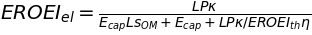

In [89]:
var('EROEI_el');
eq_S3=Eq(EROEI_el,multisub(eq_S1,[E_out,eq_S2b,E_in,eq_S2a,E_f,eq_S3i,E_th,eq_S2bii]).rhs)
eq_S3

In [90]:
#eq_S3 part 1 and eq_S4 not used

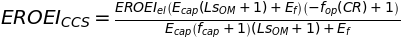

In [91]:
var('CR f_op EROEI_CCS f_cap');
eq_S5=Eq(EROEI_CCS,(1-f_op(CR))*(E_cap*(1+L*s_OM)+E_f)*EROEI_el/(E_cap*(1+f_cap)*(1+L*s_OM)+E_f))
eq_S5

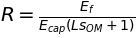

In [92]:
var('R');
eq_S6i=Eq(R,E_f/(E_cap*(1+L*s_OM)))
eq_S6i

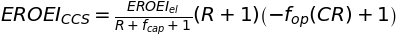

In [93]:
eq_S6=Eq(EROEI_CCS,(1-f_op(CR))*(R+1)*EROEI_el/(R+1+f_cap))
eq_S6

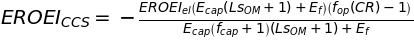

In [94]:
eq_S5.simplify()

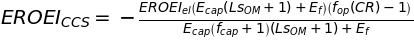

In [95]:
eq_S6.subs(R,eq_S6i.rhs).simplify()

In [96]:
#eq_S6 is correct!
eq_S6.subs(R,eq_S6i.rhs).simplify()==eq_S5.simplify()

True

#### Simulation

Using the formula in Eq.4 and the plant values from the Table S1 calculate the $EROEI_{el}$ for all capacity factors $CF$s between 50 and 90. We then use these values as a proxy to create an a adjustment factor for the $EROEI_{el}$ due to the indirect effect of the change of the capacity factor.

In [97]:
CFs=[50,55,60,65,70,75,80,85,90]
EROEI_els=[[8.8,9.2,8.8,10.7,11,26],
[9.2,9.6,9.2,11.2,11.5,27],
[9.6,10.1,9.7,11.6,12,27.8],
[10,10.5,10.1,12,12.4,28.6],
[10.3,10.8,10.5,12.4,12.8,29.3],
[10.7,11.1,10.8,12.7,13.2,29.9],
[11,11.5,11.2,13,13.5,30.5],
[11.2,11.7,11.5,13.3,13.8,31],
[11.5,12,11.8,13.5,14.1,31.5]]

In [98]:
df=pd.DataFrame(EROEI_els).T
df.columns=CFs
df.index.name='Plant #'
df.columns.name='CF'

In [99]:
df

CF,50,55,60,65,70,75,80,85,90
Plant #,,,,,,,,,
0,8.8,9.2,9.6,10.0,10.3,10.7,11.0,11.2,11.5
1,9.2,9.6,10.1,10.5,10.8,11.1,11.5,11.7,12.0
2,8.8,9.2,9.7,10.1,10.5,10.8,11.2,11.5,11.8
3,10.7,11.2,11.6,12.0,12.4,12.7,13.0,13.3,13.5
4,11.0,11.5,12.0,12.4,12.8,13.2,13.5,13.8,14.1
5,26.0,27.0,27.8,28.6,29.3,29.9,30.5,31.0,31.5


Capacity factor conversion ratio

In [100]:
(df[90]/df[50])/(90/50.0)

Plant #
0    0.726010
1    0.724638
2    0.744949
3    0.700935
4    0.712121
5    0.673077
dtype: float64

When we step up from CF 50 to 90, $EROEI_{el}$ only gets to 70% of what it should be using pure capacity factor conversion (90/50=1.8 multiplier). This is of course still dependent on the source EROEI, but let us use 0.7 for now, judging on the examined $EROEI$ ranges and the resultant conversion ratio values from the table above.

In [101]:
CF=[50,90]
CF_ratio=[1,0.7]

We need to create a similar ratio for the Capture ratio CR. We use the Energy penalty figure S1.

|CR | energy penalty  |
|--|--|
|50| 16  |
|90| 28|

In [102]:
CR=[90,50]
CR_ratio=[1, 16.0/28]

In [103]:
CR_ratio

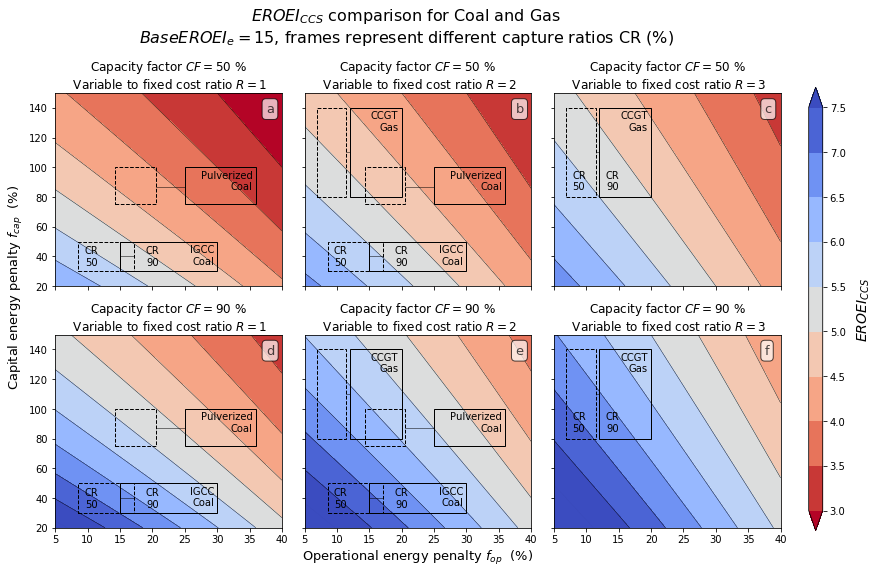

In [109]:
fop=np.linspace(5,40,100)
fcap=np.linspace(20,150,100)
R=[1,2,3]
n=0
p=0
titles=[u'$EROEI_{CCS}$ comparison for Coal and Gas']
eroei_els=[15]
names=['CCGT\nGas','Pulverized\nCoal','IGCC\nCoal']
t0s=[[12,20,80,140],[25,36,75,100],[15,30,30,50]]   
for r in range(len(titles)):
    eroei_el=eroei_els[r]
    eroei_ccs=np.zeros([len(R),len(CF),len(fop),len(fcap)])
    mmax=np.zeros([len(R),len(CF),len(CR_ratio),len(names)])
    mmin=np.zeros([len(R),len(CF),len(CR_ratio),len(names)])+1000
    for i in range(len(R)):
        for j in range(len(CF)):
            for k in range(len(fop)):
                for l in range(len(fcap)):
                    #calculate eoris over maps
                    eroei_ccs[i][j][l,k]=(1-fop[k]/100.0)*((R[i]+1)/(R[i]+1+fcap[l]/100.0))*eroei_el*CF[j]*CF_ratio[j]/100.0
                    
    fig,axes=plt.subplots(2,3,figsize=(13,8))
    plt.subplots_adjust(hspace=0.25)
    plt.subplots_adjust(wspace=0.1)
    for i in range(len(axes)):
        for j in range(len(axes[i])):
            ax=axes[i][j]
            z = eroei_ccs[j][i]
            levels = MaxNLocator(nbins=10).tick_values(eroei_el/5.0, eroei_el/2.0)
            levels2 = MaxNLocator(nbins=5).tick_values(eroei_el/5.0, eroei_el/2.0)
            cmap = plt.get_cmap('coolwarm_r')
            X, Y = np.meshgrid(fop, fcap)
            im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
            im2 = ax.contour(X, Y, z, levels=levels,extend='both',colors='k',linewidths=0.4)
            im3 = ax.contour(X, Y, z, levels=levels2,extend='both',colors='k',linewidths=0.01)
            if (i==0)and(j==1):
                fig.subplots_adjust(right=0.9)
                cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.77])
                fig.colorbar(im, cax=cbar_ax)
                cbar_ax.set_ylabel(u'$EROEI_{CCS}$',fontsize=14,labelpad=10)
            ax.set_xlim((fop.min(),fop.max()))
            ax.set_ylim((fcap.min(),fcap.max()))

            ls=['-','--']
            ls0='-'
            lw0=0.5
            for m in range(len(CR_ratio)):
                n=m*0
                for ti in range(len(t0s)):
                    if (((j!=0)and(ti==0))or((j!=2)and(ti!=0))):
                        t0=t0s[ti]
                        t=[t0[0]*CR_ratio[m],t0[1]*CR_ratio[m],t0[2]+n,t0[3]+n]
                        rect = patches.Rectangle((t[0],t[2]),t[1]-t[0],t[3]-t[2],linewidth=1,edgecolor='k',facecolor='none',ls=ls[m])
                        ax.add_patch(rect)
                        if ti==2:
                            ax.text(t[0]+2+(1-m)*3,t[3]-16,'CR\n'+str(CR[m]),horizontalalignment='center')
                        if ((j==2)):
                            if ti==0:
                                ax.text(t[0]+2+(1-m)*0,t[3]-55,'CR\n'+str(CR[m]),horizontalalignment='center')
                        if m==0: 
                            ax.text(t[1]-0.5,t[3]-15,names[ti],horizontalalignment='right')
                        else:
                            line = lines.Line2D((t0[0],t[1]),((t0[2]+t0[3])/2,(t[2]+t[3])/2),color='k',linewidth=lw0,ls=ls0)
                            ax.add_line(line)  
                            
            ax.set_title(u'Capacity factor $CF='+str(CF[i])+'$ %\n Variable to fixed cost ratio $R='+str(R[j])+'$')
            ax.text(0.93, 0.95, string.ascii_lowercase[i*3+j],
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=13,alpha=0.7,
                              bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            
            #ax.clabel(im3, fmt = '%i',inline=1, fontsize=10)
            
    axes[1][1].set_xlabel('Operational energy penalty $f_{op}$  (%)',fontsize=13)
    axes[0][0].set_ylabel('Capital energy penalty $f_{cap}$  (%)',fontsize=13,y=0)        
    axes[0][1].set_yticklabels('')   
    axes[1][1].set_yticklabels('')   
    axes[0][2].set_yticklabels('')   
    axes[1][2].set_yticklabels('')   
    axes[0][0].set_xticklabels('')   
    axes[0][1].set_xticklabels('')  
    axes[0][2].set_xticklabels('')   
    plt.suptitle(titles[r]+'\n'+r'$Base EROEI_{e}='+str(eroei_el)+'$, frames represent different capture ratios CR (%)',fontsize=16,y=1.03)
    plt.savefig('plot/fig2.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
    plt.show()

### Dispatchable Renewables Part

#### Equations

In [110]:
l=Symbol('lambda')
epse=Symbol('epsilon_e')
var('ESOI D');
eq_S7=Eq(ESOI,l*e*D/epse)
eq_S7

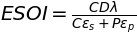

In [111]:
epsp=Symbol('epsilon_p')
epss=Symbol('epsilon_s')
var('D P C');
eq_S8=Eq(ESOI,C*l*e*D/(P*epsp+C*epss))
eq_S8

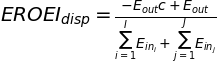

In [112]:
f=Symbol('varphi_j')
Ei=Symbol('E_{in_i}')
Ej=Symbol('E_{in_j}')
var('EROEI_disp c j i I J');
eq_S9=Eq(EROEI_disp,(E_out-(1-e)*Sum(f*E_out,(j,1,J))-c*E_out)/(Sum(Ei,(i,1,I))+Sum(Ej,(j,1,J))))
eq_S9

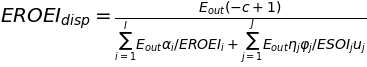

In [113]:
a=Symbol('alpha_i')
ej=Symbol('eta_j')
f=Symbol('varphi_j')
Ei=Symbol('E_{in_i}')
Ej=Symbol('E_{in_j}')
var('EROEI_i u_j ESOI_j');
eq_S10=Eq(EROEI_disp,(E_out*(1-(1-e)*Sum(f,(j,1,J))-c))/(Sum(E_out*a/EROEI_i,(i,1,I))+Sum((E_out*f*ej)/(ESOI_j*u_j),(j,1,J))))
eq_S10

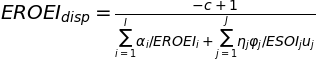

In [114]:
eq_S11=Eq(EROEI_disp,((1-(1-e)*Sum(f,(j,1,J))-c))/(Sum(a/EROEI_i,(i,1,I))+Sum((f*ej)/(ESOI_j*u_j),(j,1,J))))
eq_S11

#### Simulation

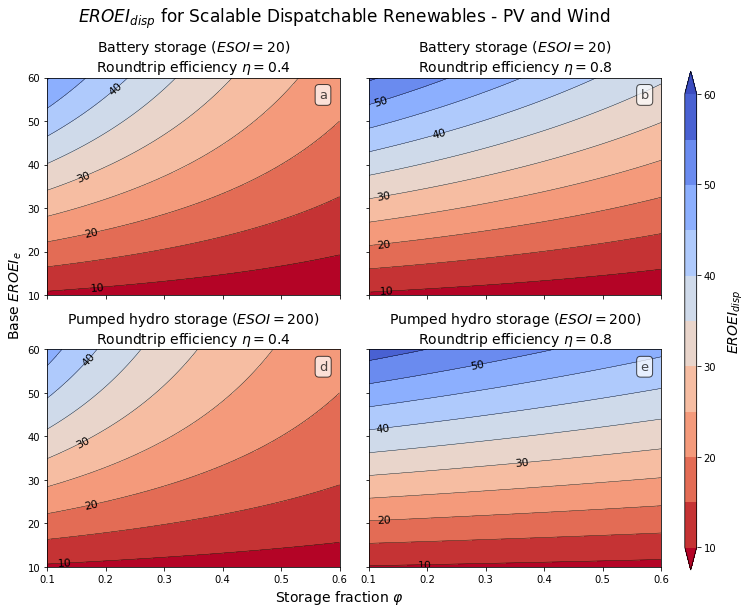

In [115]:
eroei_el=np.linspace(10,60,100)
phi=np.linspace(.10,.60,100)
ESOI=[20,200]
ESOI_tech=['Battery storage','Pumped hydro storage']
eta=[0.4,0.8]
eroei_disp=np.zeros([len(eta),len(ESOI),len(phi),len(eroei_el)])
for e in range(len(eta)):
    for i in range(len(ESOI)):
        for j in range(len(phi)):
            for k in range(len(eroei_el)):
                eroei_disp[e][i][k,j]=((1-phi[j])+(eta[e]*phi[j]))/((1/eroei_el[k])+(eta[e]*phi[j]/ESOI[i]))
fig,axes=plt.subplots(2,2,figsize=(11,9))
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=0.1)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax=axes[i][j]
        z = eroei_disp[i][j]
        levels = MaxNLocator(nbins=10).tick_values(10, 60)
        levels2 = MaxNLocator(nbins=5).tick_values(10, 60)
        cmap = plt.get_cmap('coolwarm_r')
        X, Y = np.meshgrid(phi, eroei_el)
        im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
        im2 = ax.contour(X, Y, z, levels=levels,extend='both',colors='k',linewidths=0.4)
        im3 = ax.contour(X, Y, z, levels=levels2,extend='both',colors='k',linewidths=0.01)    
        ax.clabel(im3, fmt = '%i',inline=1, fontsize=11)
        if (i==0)and(j==1):
            fig.subplots_adjust(right=0.9)
            cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.77])
            fig.colorbar(im, cax=cbar_ax)
            cbar_ax.set_ylabel(u'$EROEI_{disp}$',fontsize=14,labelpad=10)
        ax.set_xlim((phi.min(),phi.max()))
        ax.set_ylim((eroei_el.min(),eroei_el.max()))
        ax.set_title(ESOI_tech[i]+u' ($ESOI='+str(ESOI[i])+'$)\nRoundtrip efficiency $\eta='+str(eta[j])+'$',fontsize=14)
        ax.text(0.93, 0.95, string.ascii_lowercase[i*3+j],
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=13,alpha=0.7,
                              bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            
axes[1][0].set_xlabel('Storage fraction $\\varphi$',fontsize=14,x=1)
axes[0][0].set_ylabel('Base $EROEI_{e}$',fontsize=14,y=0)        
axes[0][1].set_yticklabels('')   
axes[1][1].set_yticklabels('')   
axes[0][0].set_xticklabels('')   
axes[0][1].set_xticklabels('')  
plt.suptitle(r'$EROEI_{disp}$ for Scalable Dispatchable Renewables - PV and Wind',fontsize=17,y=0.99)
plt.savefig('plot/fig3.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

Computing CCGT
Gas for EROEI
10.0 20.0 30.0 plotting...
Computing Pulverized
Coal for EROEI
7.0 10.5 14.0 plotting...
Computing IGCC
Coal for EROEI
8.0 11.5 15.0 plotting...


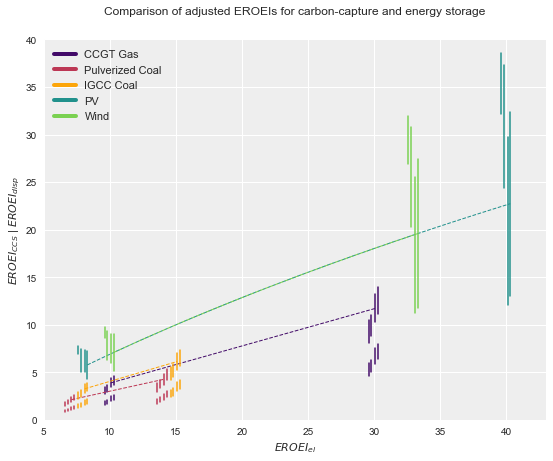

In [184]:
names=['CCGT\nGas','Pulverized\nCoal','IGCC\nCoal']
eroei_el_ns=[np.linspace(10,30,3),np.linspace(7,14,3),np.linspace(8,15,3)]   
fig, ax = plt.subplots(1,1,subplot_kw=dict(facecolor='#EEEEEE',axisbelow=True),figsize=(9,7))
ax.grid(color='white', linestyle='solid')                       
RR=[[2,3],[1,2],[1,2]]
def color(n):
    arr=range(n)
    return plt.get_cmap('viridis')(plt.Normalize(min(arr),max(arr))(arr))
def color2(n):
    arr=range(n)
    return plt.get_cmap('inferno')(plt.Normalize(min(arr),max(arr))(arr))
for n in range(len(names)):
    print 'Computing',names[n], 'for EROEI'
    R=RR[n]
    mmax=np.zeros([len(eroei_el_ns[n]),len(R),len(CF),len(CR_ratio),len(names)])
    mmin=np.zeros([len(eroei_el_ns[n]),len(R),len(CF),len(CR_ratio),len(names)])+1000
    for eroi in range(len(eroei_el_ns[n])):
        eroei_el=eroei_el_ns[n][eroi]
        print eroei_el,
        eroei_ccs=np.zeros([len(R),len(CF),len(fop),len(fcap)])
        for i in range(len(R)):
            for j in range(len(CF)):
                for k in range(len(fop)):
                    for l in range(len(fcap)):
                        for cr in range(len(CR_ratio)):
                            #calculate eoris over maps
                            eroei_ccs[i][j][l,k]=CR_ratio[cr]*((1-fop[k]/100.0)*((R[i]+1)/(R[i]+1+fcap[l]/100.0))*eroei_el*CF[j]*CF_ratio[j]/100.0)
                            #calculate minmaxes, all maps
                            for t0x in range(len(t0s[n])/2):
                                for t0y in range(len(t0s[n])/2,len(t0s[n])):
                                    x=t0s[n][t0x]
                                    y=t0s[n][t0y]
                                    if ((abs(fop[k]-x)<0.5)and(abs(fcap[l]-y)<1.5)):
                                        mmax[eroi][i][j][cr][n]=max(mmax[eroi][i][j][cr][n],eroei_ccs[i][j][l,k])
                                        mmin[eroi][i][j][cr][n]=min(mmin[eroi][i][j][cr][n],eroei_ccs[i][j][l,k])
    print 'plotting...'
    for i in range(len(R)):
        for j in range(len(CF)):
            for cr in range(len(CR_ratio)):
                x0=eroei_el_ns[n][0]+j*0.5+i*0.2-0.4
                y0min=mmin[0][i][j][cr][n]
                y0max=mmax[0][i][j][cr][n]
                x1=eroei_el_ns[n][-1]+j*0.5+i*0.2-0.4
                y1min=mmin[-1][i][j][cr][n]
                y1max=mmax[-1][i][j][cr][n]
                c=color2(11)[int(n*3+2)]
                lw=1.5
                if i==0:ls='-'
                else: ls='-'
                ax.plot([x0,x0],[y0min,y0max],c=c,lw=lw,ls=ls)
                ax.plot([x1,x1],[y1min,y1max],c=c,lw=lw,ls=ls)
                if ((i==0)&(j==1)&(cr==0)):
                    xk=eroei_el_ns[n][:]+j*0.5+i*0.2-0.4
                    ykmin=[mmin[z][i][j][cr][n] for z in range(len(mmin))]
                    ykmax=[mmax[z][i][j][cr][n] for z in range(len(mmax))]
                    ax.plot([0,0],[1,1],c=c,lw=4,label=names[n].replace('\n',' '))
                    ax.plot(xk,(np.array(ykmin)+np.array(ykmax))/2.0,c=c,lw=1,ls='--')

ren=['PV','Wind']
eroei_el_ren=[np.linspace(8,40,100),np.linspace(10,33,100)]
for n in range(len(ren)):
    eroei_el=eroei_el_ren[n]
    phi=np.linspace(.10,.60,100)
    ESOI=[200,10]
    eta=[0.8,0.4]
    eroei_disp=np.zeros([len(eta),len(ESOI),len(phi),len(eroei_el)])
    for e in range(len(eta)):
        for i in range(len(ESOI)):
            for k in range(len(eroei_el)):
                for j in range(len(phi)):
                    eroei_disp[e][i][k][j]=((1-phi[j])+(eta[e]*phi[j]))/((1/eroei_el[k])+(eta[e]*phi[j]/ESOI[i]))
            x0=eroei_el[0]+i*0.5+e*0.2-0.4
            y0min=min(eroei_disp[e][i][0])
            y0max=max(eroei_disp[e][i][0])
            x1=eroei_el[-1]+i*0.5+e*0.2-0.4
            y1min=min(eroei_disp[e][i][-1])
            y1max=max(eroei_disp[e][i][-1])
            c=color(11)[int(n*3+5)]
            ax.plot([x0,x0],[y0min,y0max],c=c,lw=lw,ls=ls)
            ax.plot([x1,x1],[y1min,y1max],c=c,lw=lw,ls=ls)
            if ((e==1)&(i==1)):
                xk=eroei_el[:]+i*0.5+e*0.2-0.4
                ykmin=[min(eroei_disp[e][i][z]) for z in range(len(eroei_disp[e][i]))]
                ykmax=[max(eroei_disp[e][i][z]) for z in range(len(eroei_disp[e][i]))]
                ax.plot([0,0],[1,1],c=c,lw=4,label=ren[n])
                ax.plot(xk,(np.array(ykmin)+np.array(ykmax))/2.0,c=c,lw=1,ls='--')                

ax.set_xlim(5,43)
ax.set_ylim(0,40)
ax.legend(loc=2,framealpha=0.5,fontsize=11)
ax.set_ylabel("$EROEI_{CCS}$ | $EROEI_{disp}$")
ax.set_xlabel("$EROEI_{el}$")
#ax.set_yscale('log')
ax.set_title('Comparison of adjusted EROEIs for carbon-capture and energy storage',y=1.05)
plt.savefig('plot/fig4.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

In [215]:
def convexhull(p):
    p = np.array(p)
    hull = ConvexHull(p)
    return p[hull.vertices,:]

Computing NGCC
Gas for EROEI
10.0 30.0 calculating points...
calculating convex hull...
plotting...
Computing Pulverized
Coal for EROEI
7.0 14.0 calculating points...
calculating convex hull...
plotting...
Computing IGCC
Coal for EROEI
8.0 15.0 calculating points...
calculating convex hull...
plotting...
calculating points...
calculating convex hull...
plotting...
calculating points...
calculating convex hull...
plotting...
calculating points...
calculating convex hull...
plotting...
calculating points...
calculating convex hull...
plotting...


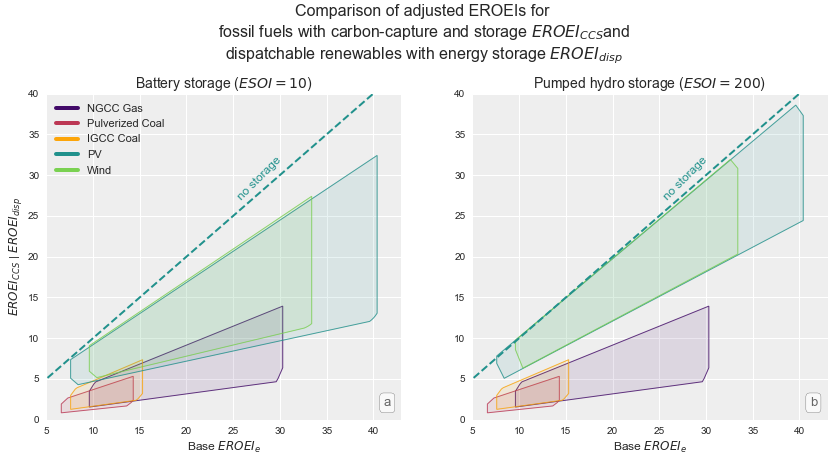

In [271]:
names=['NGCC\nGas','Pulverized\nCoal','IGCC\nCoal']
eroei_el_ns=[np.linspace(10,30,2),np.linspace(7,14,2),np.linspace(8,15,2)]   
fig, axes = plt.subplots(1,2,subplot_kw=dict(facecolor='#EEEEEE',axisbelow=True),figsize=(14,6))
axes[0].grid(color='white', linestyle='solid')                       
axes[1].grid(color='white', linestyle='solid')                       
RR=[[2,3],[1,2],[1,2]]
def color(n):
    arr=range(n)
    return plt.get_cmap('viridis')(plt.Normalize(min(arr),max(arr))(arr))
def color2(n):
    arr=range(n)
    return plt.get_cmap('inferno')(plt.Normalize(min(arr),max(arr))(arr))

for n in range(len(names)):
    print 'Computing',names[n], 'for EROEI'
    R=RR[n]
    mmax=np.zeros([len(eroei_el_ns[n]),len(R),len(CF),len(CR_ratio),len(names)])
    mmin=np.zeros([len(eroei_el_ns[n]),len(R),len(CF),len(CR_ratio),len(names)])+1000
    for eroi in range(len(eroei_el_ns[n])):
        eroei_el=eroei_el_ns[n][eroi]
        print eroei_el,
        eroei_ccs=np.zeros([len(R),len(CF),len(fop),len(fcap)])
        for i in range(len(R)):
            for j in range(len(CF)):
                for k in range(len(fop)):
                    for l in range(len(fcap)):
                        for cr in range(len(CR_ratio)):
                            #calculate eoris over maps
                            eroei_ccs[i][j][l,k]=CR_ratio[cr]*((1-fop[k]/100.0)*((R[i]+1)/(R[i]+1+fcap[l]/100.0))*eroei_el*CF[j]*CF_ratio[j]/100.0)
                            #calculate minmaxes, all maps
                            for t0x in range(len(t0s[n])/2):
                                for t0y in range(len(t0s[n])/2,len(t0s[n])):
                                    x=t0s[n][t0x]
                                    y=t0s[n][t0y]
                                    if ((abs(fop[k]-x)<0.5)and(abs(fcap[l]-y)<1.5)):
                                        mmax[eroi][i][j][cr][n]=max(mmax[eroi][i][j][cr][n],eroei_ccs[i][j][l,k])
                                        mmin[eroi][i][j][cr][n]=min(mmin[eroi][i][j][cr][n],eroei_ccs[i][j][l,k])
    print 'calculating points...'
    points=[]
    for i in range(len(R)):
        for j in range(len(CF)):
            for cr in range(len(CR_ratio)):
                x0=eroei_el_ns[n][0]+j*0.5+i*0.2-0.4
                y0min=mmin[0][i][j][cr][n]
                y0max=mmax[0][i][j][cr][n]
                x1=eroei_el_ns[n][-1]+j*0.5+i*0.2-0.4
                y1min=mmin[-1][i][j][cr][n]
                y1max=mmax[-1][i][j][cr][n]
                c=color2(11)[int(n*3+2)]
                lw=1.5
                ls='-'
                #ax.plot([x0,x0],[y0min,y0max],c=c,lw=lw,ls=ls)
                #ax.plot([x1,x1],[y1min,y1max],c=c,lw=lw,ls=ls)
                points.append([x0,y0min])
                points.append([x0,y0max])
                points.append([x1,y1min])
                points.append([x1,y1max])
                              
    print 'calculating convex hull...'
    ax=axes[1]
    poly = plt.Polygon(convexhull(points), edgecolor="k",facecolor=c,alpha=0.1)
    poly2 = plt.Polygon(convexhull(points), edgecolor=c,alpha=0.8,fill=False,lw=1)
    ax.add_patch(poly)
    ax.add_patch(poly2)
    ax=axes[0]
    poly = plt.Polygon(convexhull(points), edgecolor="k",facecolor=c,alpha=0.1)
    poly2 = plt.Polygon(convexhull(points), edgecolor=c,alpha=0.8,fill=False,lw=1)
    ax.add_patch(poly)
    ax.add_patch(poly2)
    ax.plot([0,0],[1,1],c=c,lw=4,label=names[n].replace('\n',' '))
    print 'plotting...'
    
ren=['PV','Wind']
eroei_el_ren=[np.linspace(8,40,100),np.linspace(10,33,100)]
for n in range(len(ren)):
    eroei_el=eroei_el_ren[n]
    phi=np.linspace(.10,.60,100)
    ESOI=[10]
    eta=[0.8,0.7,0.6,0.5,0.4]
    eroei_disp=np.zeros([len(eta),len(ESOI),len(phi),len(eroei_el)])
    
    print 'calculating points...'
    points=[]
    
    for e in range(len(eta)):
        for i in range(len(ESOI)):
            for k in range(len(eroei_el)):
                for j in range(len(phi)):
                    eroei_disp[e][i][k][j]=((1-phi[j])+(eta[e]*phi[j]))/((1/eroei_el[k])+(eta[e]*phi[j]/ESOI[i]))
            x0=eroei_el[0]+i*0.5+e*0.2-0.4
            y0min=min(eroei_disp[e][i][0])
            y0max=max(eroei_disp[e][i][0])
            x1=eroei_el[-1]+i*0.5+e*0.2-0.4
            y1min=min(eroei_disp[e][i][-1])
            y1max=max(eroei_disp[e][i][-1])
            c=color(11)[int(n*3+5)]
            #ax.plot([x0,x0],[y0min,y0max],c=c,lw=lw,ls=ls)
            #ax.plot([x1,x1],[y1min,y1max],c=c,lw=lw,ls=ls)
            points.append([x0,y0min])
            points.append([x0,y0max])
            points.append([x1,y1min])
            points.append([x1,y1max])  
    
    print 'calculating convex hull...'
    ax=axes[0]
    poly = plt.Polygon(convexhull(points), edgecolor="k",facecolor=c,alpha=0.1)
    poly2 = plt.Polygon(convexhull(points), edgecolor=c,alpha=0.8,fill=False,lw=1)
    ax.add_patch(poly)
    ax.add_patch(poly2)
    ax.plot([0,0],[1,1],c=c,lw=4,label=ren[n].replace('\n',' '))
    if n==0: 
        ax.plot([0,100],[0,100],c=c,lw=2,ls='--')
        ax.text(0.6, 0.74, 'no storage',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ax.transAxes,size=12,rotation=45, color=c)
    print 'plotting...'
    
for n in range(len(ren)):
    eroei_el=eroei_el_ren[n]
    phi=np.linspace(.10,.60,100)
    ESOI=[200]
    eta=[0.8,0.7,0.6,0.5,0.4]
    eroei_disp=np.zeros([len(eta),len(ESOI),len(phi),len(eroei_el)])
    
    print 'calculating points...'
    points=[]
    
    for e in range(len(eta)):
        for i in range(len(ESOI)):
            for k in range(len(eroei_el)):
                for j in range(len(phi)):
                    eroei_disp[e][i][k][j]=((1-phi[j])+(eta[e]*phi[j]))/((1/eroei_el[k])+(eta[e]*phi[j]/ESOI[i]))
            x0=eroei_el[0]+i*0.5+e*0.2-0.4
            y0min=min(eroei_disp[e][i][0])
            y0max=max(eroei_disp[e][i][0])
            x1=eroei_el[-1]+i*0.5+e*0.2-0.4
            y1min=min(eroei_disp[e][i][-1])
            y1max=max(eroei_disp[e][i][-1])
            c=color(11)[int(n*3+5)]
            #ax.plot([x0,x0],[y0min,y0max],c=c,lw=lw,ls=ls)
            #ax.plot([x1,x1],[y1min,y1max],c=c,lw=lw,ls=ls)
            points.append([x0,y0min])
            points.append([x0,y0max])
            points.append([x1,y1min])
            points.append([x1,y1max])  
    
    print 'calculating convex hull...'
    print 'plotting...'
    ax=axes[1]
    poly = plt.Polygon(convexhull(points), edgecolor="k",facecolor=c,alpha=0.1)
    poly2 = plt.Polygon(convexhull(points), edgecolor=c,alpha=0.8,fill=False,lw=1)
    ax.add_patch(poly)
    ax.add_patch(poly2)
    if n==0: 
        ax.plot([0,100],[0,100],c=c,lw=2,ls='--')
        ax.text(0.6, 0.74, 'no storage',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ax.transAxes,size=12,rotation=45, color=c)

for n,ax in enumerate(axes):
    ax.set_xlim(5,43)
    ax.set_ylim(0,40)
    ax.legend(loc=2,framealpha=0.5,fontsize=11)
    ax.set_xlabel("Base $EROEI_{e}$",fontsize=12)
    ax.text(0.95, 0.07, string.ascii_lowercase[n],
                    horizontalalignment='left',
                    verticalalignment='top',
                    transform=ax.transAxes,size=13,alpha=0.7,
                                  bbox=dict(boxstyle="round", fc="w", alpha=0.7))

axes[0].set_ylabel("$EROEI_{CCS}$ | $EROEI_{disp}$",fontsize=12)

    
axes[0].set_title('Battery storage ($ESOI=10$)',fontsize=14)
axes[1].set_title('Pumped hydro storage ($ESOI=200$)',fontsize=14)
plt.suptitle('Comparison of adjusted EROEIs for \nfossil fuels with carbon-capture and storage $EROEI_{CCS}$ and \ndispatchable renewables with energy storage $EROEI_{disp}$',y=1.08,fontsize=16)
plt.savefig('plot/fig4b.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

calculating points...
Computing CCGT
Gas for EROEI
10.0 30.0 Computing Pulverized
Coal for EROEI
7.0 14.0 Computing IGCC
Coal for EROEI
8.0 15.0 calculating convex hull...
plotting...
calculating points...
calculating convex hull...
plotting...
calculating points...
calculating convex hull...
plotting...


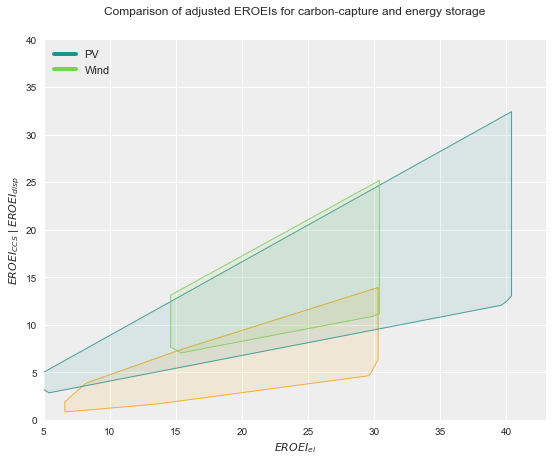

In [239]:
names=['CCGT\nGas','Pulverized\nCoal','IGCC\nCoal']
eroei_el_ns=[np.linspace(10,30,2),np.linspace(7,14,2),np.linspace(8,15,2)]   
fig, ax = plt.subplots(1,1,subplot_kw=dict(facecolor='#EEEEEE',axisbelow=True),figsize=(9,7))
ax.grid(color='white', linestyle='solid')                       
RR=[[2,3],[1,2],[1,2]]
def color(n):
    arr=range(n)
    return plt.get_cmap('viridis')(plt.Normalize(min(arr),max(arr))(arr))
def color2(n):
    arr=range(n)
    return plt.get_cmap('inferno')(plt.Normalize(min(arr),max(arr))(arr))

print 'calculating points...'
points=[]    
for n in range(len(names)):
    print 'Computing',names[n], 'for EROEI'
    R=RR[n]
    mmax=np.zeros([len(eroei_el_ns[n]),len(R),len(CF),len(CR_ratio),len(names)])
    mmin=np.zeros([len(eroei_el_ns[n]),len(R),len(CF),len(CR_ratio),len(names)])+1000
    for eroi in range(len(eroei_el_ns[n])):
        eroei_el=eroei_el_ns[n][eroi]
        print eroei_el,
        eroei_ccs=np.zeros([len(R),len(CF),len(fop),len(fcap)])
        for i in range(len(R)):
            for j in range(len(CF)):
                for k in range(len(fop)):
                    for l in range(len(fcap)):
                        for cr in range(len(CR_ratio)):
                            #calculate eoris over maps
                            eroei_ccs[i][j][l,k]=CR_ratio[cr]*((1-fop[k]/100.0)*((R[i]+1)/(R[i]+1+fcap[l]/100.0))*eroei_el*CF[j]*CF_ratio[j]/100.0)
                            #calculate minmaxes, all maps
                            for t0x in range(len(t0s[n])/2):
                                for t0y in range(len(t0s[n])/2,len(t0s[n])):
                                    x=t0s[n][t0x]
                                    y=t0s[n][t0y]
                                    if ((abs(fop[k]-x)<0.5)and(abs(fcap[l]-y)<1.5)):
                                        mmax[eroi][i][j][cr][n]=max(mmax[eroi][i][j][cr][n],eroei_ccs[i][j][l,k])
                                        mmin[eroi][i][j][cr][n]=min(mmin[eroi][i][j][cr][n],eroei_ccs[i][j][l,k])
    for i in range(len(R)):
        for j in range(len(CF)):
            for cr in range(len(CR_ratio)):
                x0=eroei_el_ns[n][0]+j*0.5+i*0.2-0.4
                y0min=mmin[0][i][j][cr][n]
                y0max=mmax[0][i][j][cr][n]
                x1=eroei_el_ns[n][-1]+j*0.5+i*0.2-0.4
                y1min=mmin[-1][i][j][cr][n]
                y1max=mmax[-1][i][j][cr][n]
                c=color2(11)[int(n*3+2)]
                lw=1.5
                ls='-'
                #ax.plot([x0,x0],[y0min,y0max],c=c,lw=lw,ls=ls)
                #ax.plot([x1,x1],[y1min,y1max],c=c,lw=lw,ls=ls)
                points.append([x0,y0min])
                points.append([x0,y0max])
                points.append([x1,y1min])
                points.append([x1,y1max])
                              
print 'calculating convex hull...'
poly = plt.Polygon(convexhull(points), edgecolor="k",facecolor=c,alpha=0.1)
poly2 = plt.Polygon(convexhull(points), edgecolor=c,alpha=0.8,fill=False,lw=1)

print 'plotting...'
ax.add_patch(poly)
ax.add_patch(poly2)
ax.plot([0,0],[1,1],c=c,lw=4)
    
    
ren=['PV','Wind']
eroei_el_ren=[np.linspace(5,40,100),np.linspace(15,30,100)]
for n in range(len(ren)):
    eroei_el=eroei_el_ren[n]
    phi=np.linspace(.10,.60,100)
    ESOI=[10]
    eta=[0.8,0.7,0.6,0.5,0.4]
    eroei_disp=np.zeros([len(eta),len(ESOI),len(phi),len(eroei_el)])
    
    print 'calculating points...'
    points=[]

    for e in range(len(eta)):
        for i in range(len(ESOI)):
            for k in range(len(eroei_el)):
                for j in range(len(phi)):
                    eroei_disp[e][i][k][j]=((1-phi[j])+(eta[e]*phi[j]))/((1/eroei_el[k])+(eta[e]*phi[j]/ESOI[i]))
            x0=eroei_el[0]+i*0.5+e*0.2-0.4
            y0min=min(eroei_disp[e][i][0])
            y0max=max(eroei_disp[e][i][0])
            x1=eroei_el[-1]+i*0.5+e*0.2-0.4
            y1min=min(eroei_disp[e][i][-1])
            y1max=max(eroei_disp[e][i][-1])
            c=color(11)[int(n*3+5)]
            #ax.plot([x0,x0],[y0min,y0max],c=c,lw=lw,ls=ls)
            #ax.plot([x1,x1],[y1min,y1max],c=c,lw=lw,ls=ls)
            points.append([x0,y0min])
            points.append([x0,y0max])
            points.append([x1,y1min])
            points.append([x1,y1max])  
    
    print 'calculating convex hull...'
    poly = plt.Polygon(convexhull(points), edgecolor="k",facecolor=c,alpha=0.1)
    poly2 = plt.Polygon(convexhull(points), edgecolor=c,alpha=0.8,fill=False,lw=1)
    
    print 'plotting...'
    ax.add_patch(poly)
    ax.add_patch(poly2)
    ax.plot([0,0],[1,1],c=c,lw=4,label=ren[n].replace('\n',' '))
    
    
ax.set_xlim(5,43)
ax.set_ylim(0,40)
ax.legend(loc=2,framealpha=0.5,fontsize=11)
ax.set_ylabel("$EROEI_{CCS}$ | $EROEI_{disp}$")
ax.set_xlabel("$EROEI_{el}$")
#ax.set_yscale('log')
ax.set_title('Comparison of adjusted EROEIs for carbon-capture and energy storage',y=1.05)
plt.savefig('plot/fig4c.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

### Auxiliary plots

In [142]:
df=pd.read_excel('cfdata.xlsx')

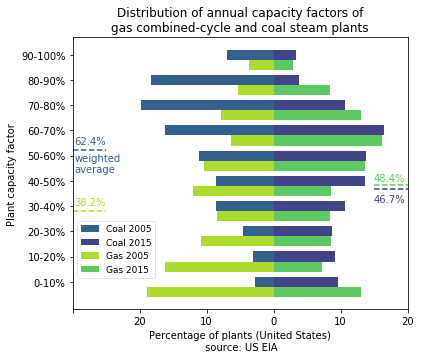

In [143]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.barh(df.index,-df['PC 2005']/sum(df['PC 2005'])*100,0.4,color=color(11)[3],label='Coal 2005')
ax.barh(df.index,df['PC 2015']/sum(df['PC 2015'])*100,0.4,color=color(11)[2],label='Coal 2015')
ax.barh(df.index-0.4,-df['NG 2005']/sum(df['NG 2005'])*100,0.4,color=color(9)[7],label='Gas 2005')
ax.barh(df.index-0.4,df['NG 2015']/sum(df['NG 2015'])*100,0.4,color=color(9)[6],label='Gas 2015')
z=np.average(df.index+0.5,weights=df['NG 2005'])-1
ax.plot([-30,-25],[z,z],ls='--',color=color(9)[7])
ax.text(-29.7,z+0.2,str(np.round((z+1)*10,1))+ '%',color=color(9)[7])
z=np.average(df.index+0.5,weights=df['NG 2015'])-1
ax.plot([15,20],[z,z],ls='--',color=color(9)[6])
ax.text(15,z+0.15,str(np.round((z+1)*10,1))+ '%',color=color(9)[6])
z=np.average(df.index+0.5,weights=df['PC 2005'])-1
ax.plot([-30,-25],[z,z],ls='--',color=color(11)[3])
ax.text(-29.7,z+0.2,str(np.round((z+1)*10,1))+ '%',color=color(11)[3])
ax.text(-29.7,z-0.9,'weighted\naverage',color=color(11)[3])
z=np.average(df.index+0.5,weights=df['PC 2015'])-1
ax.plot([15,20],[z,z],ls='--',color=color(11)[2])
ax.text(15,z-0.5,str(np.round((z+1)*10,1))+ '%',color=color(11)[2])

fig.canvas.draw()
labels = ['']+[item.get_text().replace(u'\u2212','') for item in ax.get_xticklabels()[2:-1]]+['']
ax.set_xticklabels(labels)
ax.set_yticks(df.index)
ax.set_xlim([-30,20])
ax.set_yticklabels(df['CF'][::-1])
ax.legend(bbox_to_anchor=(0.26, 0.22),framealpha=0.5,fontsize=9)
ax.set_ylabel('Plant capacity factor')
ax.set_xlabel('Percentage of plants (United States)\n source: US EIA')
ax.set_title('Distribution of annual capacity factors of\ngas combined-cycle and coal steam plants')
plt.savefig('plot/figS2.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

In [144]:
import seaborn as sns  

In [161]:
dg=[]
fuel_label={'NG':' ','PC':'  '} #just needed for pretty labels
for label in [u'NG 2005', u'NG 2015', u'PC 2015', u'PC 2005']:
    h1=df[[label]]
    for i in h1.index:
        for j in range(int(abs(h1.loc[i][label]))):
            dg.append({'Fuel':fuel_label[label[:2]],'Year':int(label[-4:]),'Capacity factor':(0.5+i)*10})

In [162]:
dh=pd.DataFrame(dg)
dh.head()

,Capacity factor,Fuel,Year
0,5.0,,2005
1,5.0,,2005
2,5.0,,2005
3,5.0,,2005
4,5.0,,2005


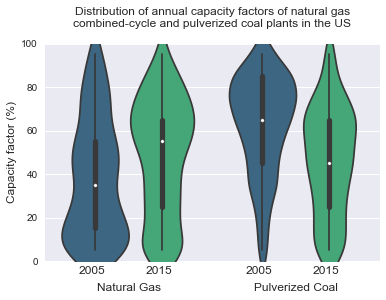

In [181]:
sns.violinplot(data=dh,x='Fuel',hue='Year',y='Capacity factor',palette="viridis")
plt.title('Distribution of annual capacity factors of natural gas\ncombined-cycle and pulverized coal plants in the US',y=1.05)
plt.xlabel('')
plt.ylabel('Capacity factor (%)',fontsize=12)
plt.legend().set_visible(False)
ax=plt.gca()
ax.text(0.1, -0.02, 2005,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.3, -0.02, 2015,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.6, -0.02, 2005,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.8, -0.02, 2015,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.75, -0.1, 'Pulverized Coal',
                horizontalalignment='center',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.25, -0.1, 'Natural Gas',
                horizontalalignment='center',
                verticalalignment='top',
                transform=ax.transAxes,size=12)

plt.ylim(0,100)   
plt.savefig('plot/figS2b.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()